# NYC Air Quality & Demographic

**Goal**: Analyze the connection between air quality and demographics profile on the borough and community district level. 

*Note: Support the The Clean Air Coalition with key findings and visuals to include in their op-ed, advocating for a new air quality bill.*

In [2]:
# load in necessary libraries
import pandas as pd 
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from siuba import *
import janitor
import contextily as cx

c:\Users\chenj\anaconda3\envs\geo_env\Lib\site-packages\janitor\utils.py:84: FutureWarning: PandasArray has been renamed NumpyExtensionArray. Use that instead. This alias will be removed in a future version.
  @_expand_grid.register(pd.arrays.PandasArray)


My Data Exploration Workflow

1. Examine Raw Data: I begin by inspecting the raw dataset to understand its structure, including data types, dimensions, and preliminary insights.

2. Segmentation and Review: I break down the data into smaller, more focused subsets to assess data quality in detail and identify potential problems. This step involves initial cleaning and basic transformations.

3. Function Application: Once I have a grasp of the overall data structure and relationships, I apply appropriate functions to the remaining raw data, prioritizing readability and maintainability within the notebook.

## Data Exploration

### Air Quality Data

**Data Source:** https://data.cityofnewyork.us/Environment/Air-Quality/c3uy-2p5r

In [3]:
# read in raw AQ dataset
aq_raw = pd.read_csv('Air_Quality_20231222.csv')
aq_raw.head()

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,172653,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,203,Bedford Stuyvesant - Crown Heights,Annual Average 2011,12/01/2010,25.30,NaN
1,172585,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,203,Bedford Stuyvesant - Crown Heights,Annual Average 2009,12/01/2008,26.93,NaN
2,336637,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,204,East New York,Annual Average 2015,01/01/2015,19.09,NaN
3,336622,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,103,Fordham - Bronx Pk,Annual Average 2015,01/01/2015,19.76,NaN
4,172582,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,104,Pelham - Throgs Neck,Annual Average 2009,12/01/2008,22.83,NaN


In [4]:
len(aq_raw)

16218

The raw AQ dataset contains 12 variables and 16218 records. It is worthy noting categorical variables could be the key to subset for more in detail analysis, including `Name`, `Geo Type Name`, `Time Period`. 

In [5]:
# check missing values
aq_raw.isna().sum() # `Message` column is not meaningful

Unique ID             0
Indicator ID          0
Name                  0
Measure               0
Measure Info          0
Geo Type Name         0
Geo Join ID           0
Geo Place Name        0
Time Period           0
Start_Date            0
Data Value            0
Message           16218
dtype: int64

In [6]:
# check duplicated records
aq_raw.duplicated().sum() # no duplicated rows

0

In [7]:
#aq_raw['Indicator ID'].unique()

# indicator id could be a useful way to filter dataset later

Focus `borough` and `community` district level analyses as per client request.

In [8]:
# Check Geo Type Names of the raw dataset
aq_raw['Geo Type Name'].unique() 

array(['UHF34', 'UHF42', 'CD', 'Borough', 'Citywide'], dtype=object)

In [9]:
# Subset the raw dataset
aq = aq_raw.drop('Message', axis=1)
aq = aq[aq['Geo Type Name'].isin(['CD','Borough'])]

For exploration, I will focus on Borough level data for now. 

In [10]:
aq_boro = aq[aq['Geo Type Name'] == 'Borough']

In [11]:
aq_boro

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value
64,211390,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,1,Bronx,Annual Average 2014,12/01/2013,19.80
132,602688,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,1,Bronx,Summer 2018,06/01/2018,13.62
133,667029,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,1,Bronx,Summer 2020,06/01/2020,13.16
134,179273,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,1,Bronx,Winter 2009-10,12/01/2009,24.39
135,549745,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,1,Bronx,Summer 2017,06/01/2017,14.97
...,...,...,...,...,...,...,...,...,...,...,...
16207,179272,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,5,Staten Island,Winter 2008-09,12/01/2008,21.63
16208,602701,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,5,Staten Island,Winter 2017-18,12/01/2017,18.92
16212,130834,648,Asthma emergency department visits due to PM2.5,Estimated annual rate (under age 18),"per 100,000 children",Borough,5,Staten Island,2005-2007,01/01/2005,55.30
16214,130780,647,Outdoor Air Toxics - Formaldehyde,Annual average concentration,µg/m3,Borough,5,Staten Island,2005,01/01/2005,2.30


To enhance the accuracy of comparing changes across three key pollutants over the ten-year period, I focused on 'Summer Average' records. This was chosen because it is the only consistent time period available for all pollutants and maximizes the comparability of the data.

In [12]:
interestedTime = ['Summer 2010', 'Summer 2020'] #'Annual Average 2010', 'Annual Average 2020', 
aq_decennial_boro = aq_boro[aq_boro['Time Period'].isin(interestedTime)]

In [13]:
aq_decennial_boro.head()

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value
133,667029,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,1,Bronx,Summer 2020,06/01/2020,13.16
137,667035,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,2,Brooklyn,Summer 2020,06/01/2020,10.82
450,669851,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,1,Bronx,Summer 2020,06/01/2020,7.24
453,669848,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,2,Brooklyn,Summer 2020,06/01/2020,6.94
714,669842,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,4,Queens,Summer 2020,06/01/2020,6.87


As for now, I would focus on Summer 2010 data to further break down the dataset and to explore the data structure. 

In [14]:
# aq_decennial = aq_decennial.pivot_wider(
#        index=['Unique ID', 'Indicator ID', 'Measure', 'Measure Info', 'Geo Type Name', 
#               'Geo Join ID', 'Geo Place Name','Time Period', 'Start_Date'
#               ],
#        names_from='Name', 
#        values_from='Data Value'
#        )

In [15]:
#Plot changes of pollutions over the years

In [16]:
aq_boro_2010 = aq_decennial_boro[aq_decennial_boro['Start_Date'] < '06/01/2020']
aq_boro_2010

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value
1997,179348,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,1,Bronx,Summer 2010,06/01/2010,19.42
2518,179575,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,3,Manhattan,Summer 2010,06/01/2010,13.41
5998,219978,386,Ozone (O3),Mean,ppb,Borough,3,Manhattan,Summer 2010,06/01/2010,28.21
11753,219972,386,Ozone (O3),Mean,ppb,Borough,2,Brooklyn,Summer 2010,06/01/2010,33.83
12138,179350,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,3,Manhattan,Summer 2010,06/01/2010,28.52
12147,219966,386,Ozone (O3),Mean,ppb,Borough,1,Bronx,Summer 2010,06/01/2010,33.16
12981,179349,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,2,Brooklyn,Summer 2010,06/01/2010,18.23
13224,219984,386,Ozone (O3),Mean,ppb,Borough,4,Queens,Summer 2010,06/01/2010,34.07
13584,179574,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,2,Brooklyn,Summer 2010,06/01/2010,11.96
13742,179351,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,4,Queens,Summer 2010,06/01/2010,17.42


I want to then pivot the table to let pollutens be columns to have a better idea of the data structure.

In [17]:
'''aq_boro_2010_no2 = aq_boro_2010[aq_boro_2010['Name'] == 'Nitrogen dioxide (NO2)']
aq_boro_2010_no2'''

"aq_boro_2010_no2 = aq_boro_2010[aq_boro_2010['Name'] == 'Nitrogen dioxide (NO2)']\naq_boro_2010_no2"

In [18]:
def pivot_dataset(df, id_column, name_column, value_column, additional_columns=None):
    """
    Function to pivot a dataset based on specified columns.

    Args:
    - df: DataFrame - The input dataset.
    - id_column: str - The column name containing IDs.
    - name_column: str - The column name containing names.
    - value_column: str - The column name containing values.
    - additional_columns: list, optional - List of additional columns to retain in the final pivot table.

    Returns:
    - DataFrame: The pivoted DataFrame.
    """
    # Pivot the table
    pivot_table = df.pivot_table(index=id_column, columns=name_column, values=value_column).reset_index()

    # Check and merge additional columns
    if additional_columns:
        additional_cols = df.drop(columns=[name_column, value_column]).drop_duplicates(subset=id_column)
        pivot_table = pd.merge(pivot_table, additional_cols, on=id_column)

    return pivot_table

In [19]:
aq_boro_2010_T = pivot_dataset(aq_boro_2010, 'Geo Join ID', 'Name', 'Data Value', additional_columns=['Unique ID', 'Indicator ID', 'Measure', 'Measure Info','Geo Type Name', 'Geo Place Name', 'Time Period','Start_Date'])

In [20]:
aq_boro_2010_T2 = aq_boro_2010.pivot_table(index='Geo Join ID', columns='Name', values='Data Value'). reset_index()
aq_interested_col = ['Unique ID', 'Indicator ID', 'Measure', 'Measure Info','Geo Type Name', 'Geo Place Name', 'Time Period','Start_Date']

aq_boro_2010_T2.merge(aq_boro_2010_T2,)


Name,Geo Join ID,Fine particles (PM 2.5),Nitrogen dioxide (NO2),Ozone (O3)
0,1,12.12,19.42,33.16
1,2,11.96,18.23,33.83
2,3,13.41,28.52,28.21
3,4,11.53,17.42,34.07
4,5,11.43,12.03,35.17


In [21]:
aq_boro_2010_T2

Name,Geo Join ID,Fine particles (PM 2.5),Nitrogen dioxide (NO2),Ozone (O3)
0,1,12.12,19.42,33.16
1,2,11.96,18.23,33.83
2,3,13.41,28.52,28.21
3,4,11.53,17.42,34.07
4,5,11.43,12.03,35.17


In [22]:
aq_boro_2010_T

,Geo Join ID,Fine particles (PM 2.5),Nitrogen dioxide (NO2),Ozone (O3),Unique ID,Indicator ID,Measure,Measure Info,Geo Type Name,Geo Place Name,Time Period,Start_Date
0,1,12.12,19.42,33.16,179348,375,Mean,ppb,Borough,Bronx,Summer 2010,06/01/2010
1,2,11.96,18.23,33.83,219972,386,Mean,ppb,Borough,Brooklyn,Summer 2010,06/01/2010
2,3,13.41,28.52,28.21,179575,365,Mean,mcg/m3,Borough,Manhattan,Summer 2010,06/01/2010
3,4,11.53,17.42,34.07,219984,386,Mean,ppb,Borough,Queens,Summer 2010,06/01/2010
4,5,11.43,12.03,35.17,219990,386,Mean,ppb,Borough,Staten Island,Summer 2010,06/01/2010


AQ pause for now, later to join with demo data

#### 其他的variables可以过一会儿再看

In [23]:
#aq.groupby(['Name','Indicator ID']).size().sort_values(ascending=False)

In [24]:
#aq.groupby('Name').size().sort_values(ascending=False)

In [25]:
#a = aq.groupby(['Indicator ID','Name','Time Period'])['Unique ID'].count().sort_values(ascending=False)

In [26]:
# try sql subset, check result size
#b = aq[aq['Name'] == 'Fine particles (PM 2.5)']

### Demographic Data

**Data Source:** https://s-media.nyc.gov/agencies/dcp/assets/files/excel/data-tools/census/census2020/nyc_decennialcensusdata_2010_2020_change-core-geographies.xlsx

In [27]:
# Read in raw Demographic dataset, 2020, 2010
demo2020_raw = pd.read_excel('./nyc_decennialcensusdata_2010_2020_change-core-geographies.xlsx', sheet_name='2020')
demo2020_raw.head()

,Year,GeoType,Borough,GeoID,BCT2020,Name,CDType,NTAType,Pop1,Pop1P,...,ROcHH2,ROcHH2P,ROcHH3,ROcHH3P,ROcHH4,ROcHH4P,ROcHH5pl,ROcHH5plP,LandAcres,LandAcresP
0,2020,NYC2020,New York City,0,NaN,NYC,NaN,NaN,8804190,100.0,...,670144,28.3,374447,15.8,263906,11.2,254065,10.7,192288.84,NaN
1,2020,Boro2020,Manhattan,1,NaN,Manhattan,NaN,NaN,1694251,100.0,...,196690,31.4,75343,12.0,43007,6.9,27660,4.4,14500.01,NaN
2,2020,Boro2020,Bronx,2,NaN,Bronx,NaN,NaN,1472654,100.0,...,102118,24.0,77071,18.1,58043,13.7,61014,14.4,26989.99,NaN
3,2020,Boro2020,Brooklyn,3,NaN,Brooklyn,NaN,NaN,2736074,100.0,...,215925,29.1,122906,16.6,84476,11.4,89012,12.0,44401.01,NaN
4,2020,Boro2020,Queens,4,NaN,Queens,NaN,NaN,2405464,100.0,...,139627,27.6,89400,17.6,70538,13.9,68090,13.4,69583.41,NaN


In [28]:
demo2010_raw = pd.read_excel('./nyc_decennialcensusdata_2010_2020_change-core-geographies.xlsx', sheet_name='2010')
demo2010_raw.head()

,Year,GeoType,Borough,GeoID,BCT2020,Name,CDType,NTAType,Pop1,Pop1P,...,ROcHH2,ROcHH2P,ROcHH3,ROcHH3P,ROcHH4,ROcHH4P,ROcHH5pl,ROcHH5plP,LandAcres,LandAcresP
0,2010,NYC2020,New York City,0,NaN,NYC,NaN,NaN,8175133,100.0,...,583087,27.2,337140,15.7,238500,11.1,245613,11.4,192288.84,NaN
1,2010,Boro2020,Manhattan,1,NaN,Manhattan,NaN,NaN,1585873,100.0,...,172568,29.3,67956,11.5,39712,6.7,33101,5.6,14500.01,NaN
2,2010,Boro2020,Bronx,2,NaN,Bronx,NaN,NaN,1385108,100.0,...,92988,23.8,71662,18.4,54582,14.0,59425,15.2,26989.99,NaN
3,2010,Boro2020,Brooklyn,3,NaN,Brooklyn,NaN,NaN,2504700,100.0,...,184310,27.8,110345,16.7,76346,11.5,83882,12.7,44401.01,NaN
4,2010,Boro2020,Queens,4,NaN,Queens,NaN,NaN,2230722,100.0,...,118398,26.6,78457,17.6,61303,13.8,62311,14.0,69583.41,NaN


For Exploration, I will focus on 2010 cunsus data at borough level, which matches scale of the exploration dataset in AQ. 

In [29]:
demo_boro_2010_raw = demo2010_raw[demo2010_raw['GeoType'] == 'Boro2020']
demo_boro_2010_raw

,Year,GeoType,Borough,GeoID,BCT2020,Name,CDType,NTAType,Pop1,Pop1P,...,ROcHH2,ROcHH2P,ROcHH3,ROcHH3P,ROcHH4,ROcHH4P,ROcHH5pl,ROcHH5plP,LandAcres,LandAcresP
1,2010,Boro2020,Manhattan,1,NaN,Manhattan,NaN,NaN,1585873,100.0,...,172568,29.3,67956,11.5,39712,6.7,33101,5.6,14500.01,NaN
2,2010,Boro2020,Bronx,2,NaN,Bronx,NaN,NaN,1385108,100.0,...,92988,23.8,71662,18.4,54582,14.0,59425,15.2,26989.99,NaN
3,2010,Boro2020,Brooklyn,3,NaN,Brooklyn,NaN,NaN,2504700,100.0,...,184310,27.8,110345,16.7,76346,11.5,83882,12.7,44401.01,NaN
4,2010,Boro2020,Queens,4,NaN,Queens,NaN,NaN,2230722,100.0,...,118398,26.6,78457,17.6,61303,13.8,62311,14.0,69583.41,NaN
5,2010,Boro2020,Staten Island,5,NaN,Staten Island,NaN,NaN,468730,100.0,...,14823,25.0,8720,14.7,6557,11.0,6894,11.6,36814.42,NaN


As per client request, raical and age are the most interested factors for this study. Below are related variables. 

| Name                              | Id        |
| :-------------------------------- | :-------- |
| Median age (years)                | MdAge     |
| Age dependency ratio              | AgDpdRt   |
| Old-age dependency ratio          | OdAgDpdRt |
| Child dependency ratio            | ChldDpdRt |
| Population per acre               | PopAcre   |
| For migrant workers               | VHUMigWrk |
| Hispanic                          | Hsp1      |
| White non-Hispanic                | WNH       |
| Black non-Hispanic                | BNH       |
| Asian non-Hispanic                | ANH       |
| Some other race non-Hispanic      | ONH       |
| Non-Hispanic of two or more races | TwoPlNH   |


In [30]:
demo_boro_2010 = (demo_boro_2010_raw 
    >> select('Year','GeoType','Borough','GeoID',
              'Name','CDType','Pop1','MdAge','AgDpdRt',
              'OdAgDpdRt','ChldDpdRt','PopAcre','VHUMigWrk',
              'Hsp1','WNH','BNH','ANH','ONH','TwoPlNH'
              )
    )

In [31]:
demo_boro_2010.isna().sum()

Year         0
GeoType      0
Borough      0
GeoID        0
Name         0
CDType       5
Pop1         0
MdAge        0
AgDpdRt      0
OdAgDpdRt    0
ChldDpdRt    0
PopAcre      0
VHUMigWrk    0
Hsp1         0
WNH          0
BNH          0
ANH          0
ONH          0
TwoPlNH      0
dtype: int64

In [32]:
demo_boro_2010.duplicated().sum()

0

In [33]:
demo_boro_2010

,Year,GeoType,Borough,GeoID,Name,CDType,Pop1,MdAge,AgDpdRt,OdAgDpdRt,ChldDpdRt,PopAcre,VHUMigWrk,Hsp1,WNH,BNH,ANH,ONH,TwoPlNH
1,2010,Boro2020,Manhattan,1,Manhattan,NaN,1585873,36.4,39.4,18.8,20.6,109.4,46,403577,761493,205340,177624,7882,29957
2,2010,Boro2020,Bronx,2,Bronx,NaN,1385108,32.8,59.0,16.7,42.3,51.3,4,741413,151209,416695,47335,12494,15962
3,2010,Boro2020,Brooklyn,3,Brooklyn,NaN,2504700,34.1,54.4,17.7,36.6,56.4,13,496285,893306,799066,260129,15904,40010
4,2010,Boro2020,Queens,4,Queens,NaN,2230722,37.2,50.5,19.3,31.2,32.1,20,613750,616727,395881,508334,39923,56107
5,2010,Boro2020,Staten Island,5,Staten Island,NaN,468730,38.4,56.1,19.8,36.4,12.7,8,81051,300169,44313,34697,1860,6640


It is worthy noting the boroughs' GeoIDs in Demo dataset are not assigned the same as AQ dataset. Will need to adjust later in analysis. 

## Join Air Quality and Demographic Data

In [34]:
# Reorder AQ's Geo Join ID of Boros to match with that of Demo census data
aqd_map = {
    'Manhattan': 1,
    'Bronx': 2,
    'Brooklyn': 3
}

aq_boro_2010_no2['Geo Join ID'] = aq_boro_2010_no2['Geo Place Name'].map(aqd_map).fillna(aq_boro_2010_no2['Geo Join ID'])

aq_boro_2010_no2.groupby(['Geo Join ID', 'Geo Place Name']).size()

NameError: name 'aq_boro_2010_no2' is not defined

In [ ]:
# Rename Demo dataset's GeoID as Geo Join ID to match that of AQ

demo_boro_2010.rename(columns={'GeoID':'Geo Join ID'}, inplace=True)

In [ ]:
test = left_join(aq_boro_2010_no2, demo_boro_2010, on='Geo Join ID')

In [ ]:
test

,Unique ID,Indicator ID,Name_x,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,...,OdAgDpdRt,ChldDpdRt,PopAcre,VHUMigWrk,Hsp1,WNH,BNH,ANH,ONH,TwoPlNH
0,179348,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,2.0,Bronx,Summer 2010,06/01/2010,...,16.7,42.3,51.3,4,741413,151209,416695,47335,12494,15962
1,179350,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,1.0,Manhattan,Summer 2010,06/01/2010,...,18.8,20.6,109.4,46,403577,761493,205340,177624,7882,29957
2,179349,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,3.0,Brooklyn,Summer 2010,06/01/2010,...,17.7,36.6,56.4,13,496285,893306,799066,260129,15904,40010
3,179351,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,4.0,Queens,Summer 2010,06/01/2010,...,19.3,31.2,32.1,20,613750,616727,395881,508334,39923,56107
4,179352,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,5.0,Staten Island,Summer 2010,06/01/2010,...,19.8,36.4,12.7,8,81051,300169,44313,34697,1860,6640


# proof of concept

In [ ]:
#demo2020.rename(columns={'GeoID':'Geo Join ID'}, inplace=True)

In [ ]:
demo2020.groupby(['Geo Join ID', 'Name']).size()

Geo Join ID  Name                              
1            Manhattan                             1
2            Bronx                                 1
3            Brooklyn                              1
4            Queens                                1
5            Staten Island                         1
                                                  ..
413          Queens Community District 13          1
414          Queens Community District 14          1
501          Staten Island Community District 1    1
502          Staten Island Community District 2    1
503          Staten Island Community District 3    1
Length: 64, dtype: int64

In [ ]:
aq_decennial.groupby(['Geo Join ID', 'Geo Place Name']).size()

Geo Join ID  Geo Place Name                   
1            Bronx                                6
2            Brooklyn                             6
3            Manhattan                            6
4            Queens                               6
5            Staten Island                        6
                                                 ..
413          Queens Village (CD13)                6
414          Rockaway and Broad Channel (CD14)    6
501          St. George and Stapleton (CD1)       6
502          South Beach and Willowbrook (CD2)    6
503          Tottenville and Great Kills (CD3)    6
Length: 64, dtype: int64

In [ ]:
test2 = left_join(aq_decennial, demo2020, on='Geo Join ID')

In [ ]:
demo2020

,Year,GeoType,Borough,Geo Join ID,Name,CDType,Pop1,MdAge,AgDpdRt,OdAgDpdRt,ChldDpdRt,PopAcre,VHUMigWrk,Hsp1,WNH,BNH,ANH,ONH,TwoPlNH
1,2020,Boro2020,Manhattan,1,Manhattan,NaN,1694251,36.9,43.8,24.0,19.7,116.8,52,402640,793294,199592,219624,16112,62989
2,2020,Boro2020,Bronx,2,Bronx,NaN,1472654,35.6,58.4,20.8,37.6,54.6,18,806463,130796,419393,67766,19866,28370
3,2020,Boro2020,Brooklyn,3,Brooklyn,NaN,2736074,35.2,54.8,21.1,33.7,61.6,48,516426,968427,729696,370776,37579,113170
4,2020,Boro2020,Queens,4,Queens,NaN,2405464,39.1,52.9,23.9,29.0,34.6,46,667861,549358,381375,656583,66175,84112
5,2020,Boro2020,Staten Island,5,Staten Island,NaN,495747,40.4,63.0,28.0,35.0,13.5,4,96960,277981,46835,58753,3900,11318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2020,CD,Queens,413,Queens Community District 13,CD,199218,42.3,57.5,29.2,28.4,24.9,6,24911,18192,102711,36954,7057,9393
67,2020,CD,Queens,414,Queens Community District 14,CD,124173,37.7,68.1,26.8,41.3,28.9,0,28592,40183,44867,3553,2355,4623
73,2020,CD,Staten Island,501,Staten Island Community District 1,CD,189663,37.4,60.4,23.0,37.4,21.7,3,58955,62560,40093,20632,1995,5428
74,2020,CD,Staten Island,502,Staten Island Community District 2,CD,140795,42.0,66.0,32.1,33.8,10.7,0,20181,85970,4901,25887,1052,2804


In [ ]:
aq_decennial_test = aq_decennial

In [ ]:
aqdt_map = {
    'Manhattan': 1,
    'Bronx': 2,
    'Brooklyn': 3
}

In [ ]:
aq_decennial_test['Geo Join ID'] = aq_decennial_test['Geo Place Name'].map(aqdt_map).fillna(aq_decennial_test['Geo Join ID'])

In [ ]:
aq_decennial_test.groupby(['Geo Join ID', 'Geo Place Name']).size()

Geo Join ID  Geo Place Name                   
1.0          Manhattan                            6
2.0          Bronx                                6
3.0          Brooklyn                             6
4.0          Queens                               6
5.0          Staten Island                        6
                                                 ..
413.0        Queens Village (CD13)                6
414.0        Rockaway and Broad Channel (CD14)    6
501.0        St. George and Stapleton (CD1)       6
502.0        South Beach and Willowbrook (CD2)    6
503.0        Tottenville and Great Kills (CD3)    6
Length: 64, dtype: int64

id boro
1 manhattan
1 manhattan
2 brooklyn
3 bronx
4 queens

concat demo2010 to demo2020

In [ ]:
test = pd.concat([demo2010,demo2020])

In [ ]:
test

,Year,GeoType,Borough,GeoID,Name,CDType,Pop1,MdAge,AgDpdRt,OdAgDpdRt,ChldDpdRt,PopAcre,VHUMigWrk,Hsp1,WNH,BNH,ANH,ONH,TwoPlNH,Geo Join ID
1,2010,Boro2020,Manhattan,1,Manhattan,NaN,1585873,36.4,39.4,18.8,20.6,109.4,46,403577,761493,205340,177624,7882,29957,NaN
2,2010,Boro2020,Bronx,2,Bronx,NaN,1385108,32.8,59.0,16.7,42.3,51.3,4,741413,151209,416695,47335,12494,15962,NaN
3,2010,Boro2020,Brooklyn,3,Brooklyn,NaN,2504700,34.1,54.4,17.7,36.6,56.4,13,496285,893306,799066,260129,15904,40010,NaN
4,2010,Boro2020,Queens,4,Queens,NaN,2230722,37.2,50.5,19.3,31.2,32.1,20,613750,616727,395881,508334,39923,56107,NaN
5,2010,Boro2020,Staten Island,5,Staten Island,NaN,468730,38.4,56.1,19.8,36.4,12.7,8,81051,300169,44313,34697,1860,6640,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2020,CD,Queens,NaN,Queens Community District 13,CD,199218,42.3,57.5,29.2,28.4,24.9,6,24911,18192,102711,36954,7057,9393,413
67,2020,CD,Queens,NaN,Queens Community District 14,CD,124173,37.7,68.1,26.8,41.3,28.9,0,28592,40183,44867,3553,2355,4623,414
73,2020,CD,Staten Island,NaN,Staten Island Community District 1,CD,189663,37.4,60.4,23.0,37.4,21.7,3,58955,62560,40093,20632,1995,5428,501
74,2020,CD,Staten Island,NaN,Staten Island Community District 2,CD,140795,42.0,66.0,32.1,33.8,10.7,0,20181,85970,4901,25887,1052,2804,502


## End Proof of concept
---

## Spatial Boiundaries

In [ ]:
import geopandas as gpd

In [ ]:
boro_url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'

boro = gpd.read_file(boro_url)

In [ ]:
boro

,OBJECTID,BoroCode,BoroName,Shape__Area,Shape__Length,geometry
0,1,5,Staten Island,1.623623e+09,325908.454204,"MULTIPOLYGON (((-74.05051 40.56643, -74.05047 ..."
1,2,1,Manhattan,6.365202e+08,357674.419620,"MULTIPOLYGON (((-74.01093 40.68450, -74.01193 ..."
2,3,2,Bronx,1.187177e+09,463169.939778,"MULTIPOLYGON (((-73.89681 40.79582, -73.89694 ..."
3,4,3,Brooklyn,1.934138e+09,728132.409218,"MULTIPOLYGON (((-73.86328 40.58389, -73.86381 ..."
4,5,4,Queens,3.041419e+09,888171.049923,"MULTIPOLYGON (((-73.82645 40.59054, -73.82643 ..."


<Axes: >

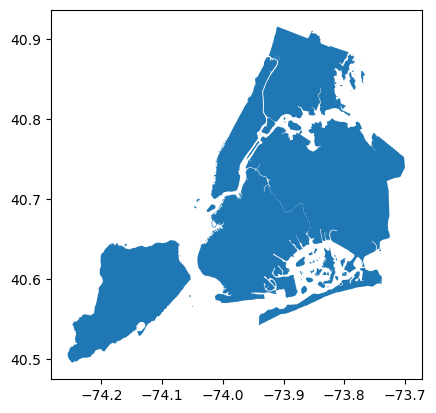

In [ ]:
boro.plot()

In [ ]:
community_url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Community_Districts/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'

community = gpd.read_file(community_url)

In [ ]:
community.head()

,OBJECTID,BoroCD,Shape__Area,Shape__Length,geometry
0,1,308,4.560400e+07,38232.751052,"POLYGON ((-73.95829 40.67984, -73.95596 40.679..."
1,2,414,1.955772e+08,210910.875979,"MULTIPOLYGON (((-73.90972 40.56530, -73.90973 ..."
2,3,204,5.552218e+07,31358.425193,"POLYGON ((-73.90269 40.84459, -73.90271 40.844..."
3,4,228,9.293902e+07,122138.942942,"MULTIPOLYGON (((-73.77322 40.86080, -73.77326 ..."
4,5,205,3.831698e+07,29443.048118,"POLYGON ((-73.89138 40.86171, -73.89142 40.861..."


<Axes: >

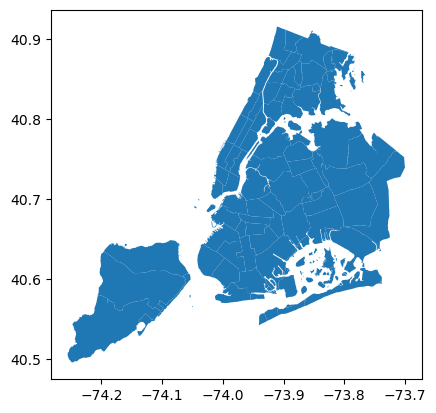

In [ ]:
community.plot()

# test mapping

In [ ]:
boro.rename(columns={'BoroCode':'Geo Join ID'}, inplace=True)

In [ ]:
test

,Unique ID,Indicator ID,Name_x,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,...,OdAgDpdRt,ChldDpdRt,PopAcre,VHUMigWrk,Hsp1,WNH,BNH,ANH,ONH,TwoPlNH
0,179348,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,2.0,Bronx,Summer 2010,06/01/2010,...,16.7,42.3,51.3,4,741413,151209,416695,47335,12494,15962
1,179350,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,1.0,Manhattan,Summer 2010,06/01/2010,...,18.8,20.6,109.4,46,403577,761493,205340,177624,7882,29957
2,179349,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,3.0,Brooklyn,Summer 2010,06/01/2010,...,17.7,36.6,56.4,13,496285,893306,799066,260129,15904,40010
3,179351,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,4.0,Queens,Summer 2010,06/01/2010,...,19.3,31.2,32.1,20,613750,616727,395881,508334,39923,56107
4,179352,375,Nitrogen dioxide (NO2),Mean,ppb,Borough,5.0,Staten Island,Summer 2010,06/01/2010,...,19.8,36.4,12.7,8,81051,300169,44313,34697,1860,6640


In [ ]:
boro

,OBJECTID,Geo Join ID,BoroName,Shape__Area,Shape__Length,geometry
0,1,5,Staten Island,1.623623e+09,325908.454204,"MULTIPOLYGON (((-74.05051 40.56643, -74.05047 ..."
1,2,1,Manhattan,6.365202e+08,357674.419620,"MULTIPOLYGON (((-74.01093 40.68450, -74.01193 ..."
2,3,2,Bronx,1.187177e+09,463169.939778,"MULTIPOLYGON (((-73.89681 40.79582, -73.89694 ..."
3,4,3,Brooklyn,1.934138e+09,728132.409218,"MULTIPOLYGON (((-73.86328 40.58389, -73.86381 ..."
4,5,4,Queens,3.041419e+09,888171.049923,"MULTIPOLYGON (((-73.82645 40.59054, -73.82643 ..."


In [ ]:
# join borough data to map

boro_2010_no2 = left_join(boro, test, on='Geo Join ID')

In [ ]:
boro_2010_no2.columns

Index(['OBJECTID', 'Geo Join ID', 'BoroName', 'Shape__Area', 'Shape__Length',
       'geometry', 'Unique ID', 'Indicator ID', 'Name_x', 'Measure',
       'Measure Info', 'Geo Type Name', 'Geo Place Name', 'Time Period',
       'Start_Date', 'Data Value', 'Year', 'GeoType', 'Borough', 'Name_y',
       'CDType', 'Pop1', 'MdAge', 'AgDpdRt', 'OdAgDpdRt', 'ChldDpdRt',
       'PopAcre', 'VHUMigWrk', 'Hsp1', 'WNH', 'BNH', 'ANH', 'ONH', 'TwoPlNH'],
      dtype='object')

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
boro_2010_no2.plot(column='Data Value', legend=True, ax=ax)

NameError: name 'plt' is not defined

# Transform DF

In [ ]:
aq2010test = aq_boro_2010 # boro level

In [ ]:
testtable = aq2010test.pivot(index='Geo Join ID', columns='Name', values='Data Value').reset_index()

In [ ]:
aq2010test.columns

Index(['Unique ID', 'Indicator ID', 'Name', 'Measure', 'Measure Info',
       'Geo Type Name', 'Geo Join ID', 'Geo Place Name', 'Time Period',
       'Start_Date', 'Data Value'],
      dtype='object')

In [ ]:
testtable

Name,Geo Join ID,Fine particles (PM 2.5),Nitrogen dioxide (NO2),Ozone (O3)
0,1,12.12,19.42,33.16
1,2,11.96,18.23,33.83
2,3,13.41,28.52,28.21
3,4,11.53,17.42,34.07
4,5,11.43,12.03,35.17


In [ ]:
def aq_pivot(df, id_column, name_column, value_column, drop=None):
    """
    Function to pivot a dataset based on specified columns.

    Args:
    - df: dataframe - Air Quality dataset
    - id_column: str - The column name containing IDs.
    - name_column: str - The column name containing names.
    - value_column: str - The column name containing values.
    - additional_columns: list, optional - List of additional columns to retain in the final pivot table.

    Returns:
    - DataFrame: The pivoted DataFrame.
    """
    # Pivot the table
    pivot_table = df.pivot_table(index=id_column, columns=name_column, values=value_column).reset_index()

    # Check and merge additional columns
    if drop:
        drop_cols = df.drop(
            columns=[
                name_column, value_column, 'Unique ID', 'Indicator ID', 'Measure', 'Measure Info','Geo Type Name'
                ]
            ).drop_duplicates(
                subset=id_column
                )
        pivot_table = pd.merge(pivot_table, drop_cols, on=id_column)

    return pivot_table

In [ ]:
testtable2 = aq_pivot(aq, 'Geo Join ID', 'Name', 'Data Value', drop=True)

In [ ]:
testtable2.columns

Index(['Geo Join ID', 'Fine particles (PM 2.5)', 'Nitrogen dioxide (NO2)',
       'Ozone (O3)', 'Time Period', 'Start_Date'],
      dtype='object')

In [ ]:
testtable2

,Geo Join ID,Annual vehicle miles traveled,Annual vehicle miles travelled (cars),Annual vehicle miles travelled (trucks),Asthma emergency department visits due to PM2.5,Asthma emergency departments visits due to Ozone,Asthma hospitalizations due to Ozone,Boiler Emissions- Total NOx Emissions,Boiler Emissions- Total PM2.5 Emissions,Boiler Emissions- Total SO2 Emissions,...,Deaths due to PM2.5,Fine particles (PM 2.5),Nitrogen dioxide (NO2),Outdoor Air Toxics - Benzene,Outdoor Air Toxics - Formaldehyde,Ozone (O3),Respiratory hospitalizations due to PM2.5 (age 20+),Geo Place Name,Time Period,Start_Date
0,1,24.00,22.90,2.00,126.40500,128.8125,25.1000,41.10,1.05,8.30,...,55.7975,9.354103,19.904103,1.613333,2.303333,30.410714,22.2450,Bronx,Annual Average 2014,12/01/2013
1,2,23.00,22.80,1.00,64.97000,72.9875,13.1750,22.80,0.10,0.75,...,49.2900,9.057692,19.900256,1.803333,2.250000,31.172143,13.7325,Brooklyn,Winter 2011-12,12/01/2011
2,3,46.70,45.85,2.50,89.38500,84.3500,12.0750,151.95,4.80,38.70,...,49.0050,10.587692,26.346154,2.566667,2.733333,27.058571,12.8600,Manhattan,Annual Average 2015,01/01/2015
3,4,24.80,23.60,1.10,42.96625,49.8875,9.5125,15.85,0.25,1.80,...,39.8650,8.691282,18.854103,1.446667,2.076667,31.695714,11.3450,Queens,Annual Average 2020,01/01/2020
4,5,9.70,9.50,0.50,36.12250,46.3000,8.6000,2.70,0.00,0.10,...,54.2875,8.335385,14.344615,1.140000,1.793333,31.137857,15.0750,Staten Island,Annual Average 2011,12/01/2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,413,30.60,29.90,0.60,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.210000,17.376154,1.110000,1.800000,32.214286,NaN,Queens Village (CD13),Annual Average 2011,12/01/2010
60,414,6.10,5.95,0.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.667949,12.863077,0.800000,1.500000,36.177857,NaN,Rockaway and Broad Channel (CD14),Annual Average 2009,12/01/2008
61,501,12.05,11.40,0.55,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.545641,17.712564,1.220000,1.800000,29.516429,NaN,St. George and Stapleton (CD1),Annual Average 2011,12/01/2010
62,502,12.15,11.40,0.65,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.376410,14.273590,1.040000,1.700000,31.202143,NaN,South Beach and Willowbrook (CD2),Summer 2014,06/01/2014


In [ ]:
demo_boro_2010.columns

Index(['Year', 'GeoType', 'Borough', 'Geo Join ID', 'Name', 'CDType', 'Pop1',
       'MdAge', 'AgDpdRt', 'OdAgDpdRt', 'ChldDpdRt', 'PopAcre', 'VHUMigWrk',
       'Hsp1', 'WNH', 'BNH', 'ANH', 'ONH', 'TwoPlNH'],
      dtype='object')

# function apply to all

In [ ]:
# boro level
## air quality data
# 1. From 'geo type name' select borouge
# 2. From 'time period' select summer 2020 and summer 2010
# 3. pivot the dataset 
# 4. set the 'time period' column value to int
# 5. leave only air pollutent colu,ns and time and geo join id
## demographic data
# 6. from raw dataset 'geotype' select boro2020
# 7. select only interested columns
## merage AQ and Demo datasets
# 8 Merge datasets

In [ ]:
def 

In [ ]:
'''def generate_datasets(AQ_raw_data, Demo_raw_data_2020, Demo_raw_data_2010):
    # Filter air quality data for boroughs and summer 2020 and 2010
    aq_data = AQ_raw_data[(AQ_raw_data['Geo Type Name'] == 'Borough') & 
                       (AQ_raw_data['Time Period'].isin(['Summer 2020', 'Summer 2010']))]

    # Pivot the air quality dataset
    aq_pivot = pivot_dataset(aq_data, 'Geo Join ID', 'Name', 'Data Value', additional_columns=['Unique ID', 'Indicator ID', 'Measure', 'Measure Info','Geo Type Name', 'Geo Place Name', 'Time Period','Start_Date'])
    
   #

    # Filter demographic data for boro2020 and select interested columns
    demo_data_2020 = Demo_raw_data_2020[(Demo_raw_data_2020['GeoType'] == 'boro2020')]
    demo_selected_2020 = demo_data_2020[['Geo Join ID', 'Borough', 'MdAge', 'AgDpdRt', 'OdAgDpdRt', 'ChldDpdRt', 
                               'WNH', 'BNH', 'ANH', 'ONH', 'TwoPlNH']]
    
    # Filter demographic data for boro2020 and select interested columns
    demo_data_2010 = Demo_raw_data_2010[(Demo_raw_data_2010['GeoType'] == 'boro2020')]
    demo_selected_2010 = demo_data_2010[['Geo Join ID', 'Borough', 'MdAge', 'AgDpdRt', 'OdAgDpdRt', 'ChldDpdRt', 
                               'WNH', 'BNH', 'ANH', 'ONH', 'TwoPlNH']]
    
    demo_data = pd.concat([demo_data_2020,demo_data_2010])

    # Merge air quality and demographic datasets
    merged_data = pd.merge(aq_pivot, demo_selected_2010, on='Geo Join ID', how='inner')
    
    return merged_data

# Example usage:
# raw_data = ... # Your raw dataset
# result_dataset = generate_datasets(raw_data)
# print(result_dataset)'''


In [ ]:
testFun = generate_datasets(aq_raw, demo2020_raw,demo2010_raw)

KeyError: "['Geo Join ID'] not in index"

# Linear Regression